Training a HMM
===========

Now our data is cleaned and augmented ready for training we can dive into creating our model and training it. 

Creating the model architecture
======

Going back to the first tutorial we will need to think about our observables and how they relate to our hidden states, and also how our hidden states interact with each other. For the start we'll be creating the simplest of HMM we can for our dataset. We'll take our obseravbles immobile, micro movements, and walking and assume they are governed by just 2 hidden states, asleep and awake.

We'll create a pictogram of it:

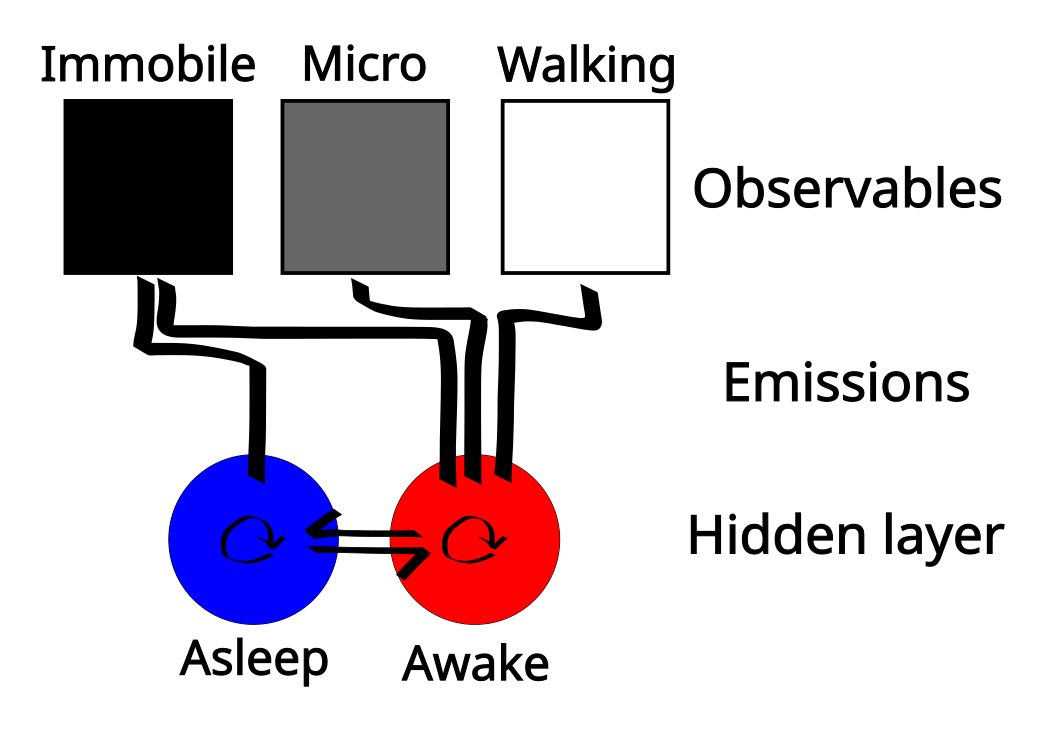

We can now translate our ideas to a starting transition matrix. When training a HMM you start with an intialised transition and emission matrix, then during the training it will make small changes to these parameters within a loop, running the forward-backward algorithm we discussed and outputting a score, which it will aim to improve. Once it has found its changes are no longer increasing the score at an a given rate it will end the training. So the intial matrix decides the starting point for the training, but it's not very important that it's close to the reality, as it will interatively update towards it during training.
For now we'll make a rough estimate of the transition rates.

In [ ]:
# First we'll create lists with our state and observable names so we know their order
# Remember previously we had to convert our observable values to 0, 1, 2 and this is reflected in our list order
# Likewise with the hidden states, the output of the model when decoding observable runs will have asleep as 0 and awake as 1
observables = ['immobile', 'micro', 'walking']
hidden_states = ['asleep', 'awake']

In [ ]:
import numpy as np

# Following on from the first part of the tutorial, each row in the matrix is a hidden state and each column is the hidden state it is transitioning into
# Remember the sum of each row must equal 1 and the shape is the number of states x itself. So 2 x 2
t_prob = np.array(  [[0.7, 0.3],
                    [0.2, 0.8]]
                )

# We now do the same for the emission probabilities
# Where we give it a zero value it tells the model that these emissions can't be attributed to a hidden state. So here the asleep state can only have immobile as its emission
em_prob =  np.array([[1.0, 0.0, 0.0],
                    [0.3, 0.3, 0.4],])

Preparing the data for the model
=========

In [ ]:
import pandas as pd
import numpy as np

# Load the cleaned data from the previous notebook 
df = pd.read_pickle('Users path to cleaned data pickle')

In [ ]:
df

In [ ]:
# First we want to change our data format from pandas to numpy
# Once again call groupby with the 'hmm' column selected and this time apply a numpy array

ar_data = df.groupby('id')['hmm'].apply(np.array)

In [ ]:
# This returns a pandas series with each flies data made into a numpy array
# A pandas series is like a single column from a dataframe
print(type(ar_data)) # use type to find what your variable is
ar_data

In [ ]:
# Now we can make it a nested array rather than a series
ar_data = np.array(ar_data)

In [ ]:
# With numpy you can check the shape of the array with .shape, we can see below that its shape is the number of flies with have in the filtered dataset
ar_data.shape

Splitting the data into test/train
======

When training a model its important to split the dataset into a portion you train and a portion you test, as you can't score the model using the data it usesd to train the model as it will be overfitted to it.

A common technique is to use 10% of the dataset for testing post training, with the remaining 90% for the model. Many packages like [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) (a commmon machine learning package) have built in functions, but given its simplicity we'll code one ourselves.

In [ ]:
# First we'll need to get the number of flies that equal 10%
test_size = 10
test_train_split = round(len(ar_data) * (test_size/100))
# Numpy random.permutations will shuffle the order
rand_runs = np.random.permutation(ar_data)
# Using square brackets after the np.array selects for arrays of a given indices 
# e.g array[0:10] would select the 1st array to the 9th, as 10 is the first array not to be included
# Not putting a number before or after the colon means either from the first or to the last array respectively 
train = rand_runs[test_train_split:]
test = rand_runs[:test_train_split]

In [ ]:
# Quickly check the shape to see if it looks right 
train.shape

In [ ]:
test.shape

Shaping the data for the model
=====

Hmmlearn models accept data formatted in a particular way. Firstly, the seqeunce for each specimen must be be an array where each data point is a single array, see the code below.

```
    X = [[1], [0], [0], [2], ...]
```

Secondly, when working with multiple sequences they must all be concatenated (joined) into a single array with a secondary array made that contains the lengths of each seqeunce. See below.

```
    X1 = [[1], [0], [0], [2]]
    X2 = [[0], [0], [1]]

    X = np.concatenate([X1, X2])
    lengths = [len(X1), len(X2)]
```

Lets get the lengths of each sequence fist. We can use a technique called list comprehension, which is a quicker way to create a list that would normally need a for loop. See [here](https://www.w3schools.com/python/python_lists_comprehension.asp) for more information on it.

In [ ]:
# Using a for loop we can get the length of each array 
for i in test:
    print(len(i))

In [ ]:
# Creating a list comprehension puts the for loop into 1 line within a list, with the loop action taking place on the far left
# The example below takes an array and divides it in 2
test_array = np.array([4,4,4,4,4])
[n/2 for n in test_array]

In [ ]:
# Apply the logic above to create the list of lengths below

# len_seq_train = []
# len_seq_test = []

len_seq_train = [len(ar) for ar in train]
len_seq_test = [len(ar) for ar in test]

The next step is to join all the sequences and reshape the final singular array 

In [ ]:
# As our data is in a nested array we can call np.concatenate on the whole thing and it will flatten it into a singluar array
seq_train = np.concatenate(train, axis = 0) # setting the axis as 0 means the action happens across the rows, axis 1 would mean the columns
seq_test = np.concatenate(test, 0)

seq_train

Numpy arrays have a built in method .reshape to give it a new shape, you pass the shape inside brackets. For example a shape of (3, 2) would have the data consist of 3 arrays with two columns each. See below.

```
a = np.array([0, 1, 2, 3, 4, 5])
a.reshape((3, 2))
array([[0, 1],
       [2, 3],
       [4, 5]])
```

Having each data point as its own array is essentially a single column array, so a shape (6, 1) for above would create the right shape, with 6 being the length of the array

```
a = a.reshape((6, 1))
array([[0],
       [1],
       [2],
       [3],
       [4],
       [5]])
```

We can get the length of the array programatically with len(), but we can also get it by calling -1 instead, which calls for a one shape dimension.

```
a = a.reshape((-1, 1))
array([[0],
       [1],
       [2],
       [3],
       [4],
       [5]])
```

In [ ]:
# Use what is shown above to reshape the array
seq_train =
seq_test =

seq_train

Inialising the model
=======

In this next section we'll generate our HMM from the hmmlearn package. The best way to fully understand a model is to look at the packages API docstrings, most pacakges will have a website page with them all. Head to this link -> [here](https://hmmlearn.readthedocs.io/en/latest/api.html#categoricalhmm) to see the docstrings for the categorical HMM, the one we'll be using.

Hmmlearn has lots of different HMM that vary with the emission type, discrete (our one) emissions is the most simple.

### hmmlearn docstring
CategoricalHMM(n_components=1, startprob_prior=1.0, transmat_prior=1.0, emissionprob_prior=1.0, n_features=None, algorithm='viterbi', random_state=None, n_iter=10, tol=0.01, verbose=False, params='ste', init_params='ste', implementation='log')

Hidden Markov Model with categorical (discrete) emissions.

Variables
:
n_components (int) – Number of hidden states.

n_features (int) – Number of possible symbols emitted by the model (in the samples).

params (string, optional) – The parameters that get updated during (params) or initialized before (init_params) the training. Can contain any combination of ‘s’ for startprob, ‘t’ for transmat, and ‘e’ for emissionprob. Defaults to all parameters.

init_params (string, optional) – The parameters that get updated during (params) or initialized before (init_params) the training. Can contain any combination of ‘s’ for startprob, ‘t’ for transmat, and ‘e’ for emissionprob. Defaults to all parameters.

verbose (bool, optional) – Whether per-iteration convergence reports are printed.

In [ ]:
# First we import the model we want from the hmmlearn package
from hmmlearn.hmm import CategoricalHMM

In [ ]:
# Simply save the model to a variable to instialise it
model = CategoricalHMM()

In [ ]:
# However we're going to want to fill it with our what we've made prior, the transtion and emission matrices
# Enter the correct arguments given the docstring information below. Hint: if you don't have the transition matrix set it as 1.0 (the default)
# With verbose as True we can see the updating scores in real time
model = CategoricalHMM(n_components =,  n_features = , params = , init_params = , verbose = True)

In [ ]:
# We next need to set our starting transition and emission matrices
# We do this by setting the attributes directly
model.transmat_ = t_prob # .transmat_ is the transtion matrix attribute
model.emissionprob_ = em_prob # ._emissionprob_ is the emission probabilities matrix attribute

In [ ]:
# Call the .fit() method with the sequence and length data to train the model 
# Given the size of the dataset and the default iteration number (10) it'll be very quick
model.fit(seq_train, len_seq_train)

In [ ]:
# We now have a trained HMM model!
# We can view the transition matrices as so
print(f'Transition matrix: \n {model.transmat_} \n')

print(f'Emission probabilities: \n {model.emissionprob_}')

In the misc folder there is a pre-made function to better view the probability arrays

In [ ]:
# As in notebook 1 we'll add the HMM folder to path and import from misc
import sys
sys.path.append('../src/HMM')
from misc import hmm_display

hmm_display(model, hidden_states, observables)

There are two parameters we can change to stop the training when we believe its reached near to its optimal point tol and number of iterations. Tol is the convergence threshold, the point at which the model stops iterating as the gain in log-liklihood is below the given value. When training with verbose as True we can see the logliklihood printed to screen on the left with the right hand column containing the difference to the prior iteration:
```
log liklihood score     --> 1 -1518089.61094345             +nan
                            2 -1093181.25787965 +424908.35306380
                            3 -1089743.31215639   +3437.94572327
                            4 -1088738.07582637   +1005.23633002
                            5 -1088379.61034925    +358.46547712
                            6 -1088211.51535954    +168.09498971
                            7 -1088110.95060934    +100.56475020
                            8 -1088041.78427272     +69.16633661
                            9 -1087991.29922729     +50.48504543
                            10 -1087953.64539560     +37.65383169  <-- logliklihood difference
``` 
If the right hand vlaue drops below the tol value, the default is 0.01, the training stops.

As we can see in the example above the logliklihood difference never dropped below 0.01, but the training was still stopped. This is due to a iteration limit, whose default is 10, that caps the number. When training you need to balence the amount of computer time you can dedicate to training versus the fittness of the model

Have a play around will different iteration numbers and tol to see how it affects the training time and the diminishing logliklihood difference as you increase the iteration number with parameters 'tol' and 'n_iter' respectively.

In [ ]:
model = CategoricalHMM(tol = , n_iter = , n_components = len(hidden_states),  n_features = len(observables), params = 'ste', init_params = 'ste', verbose = True)
model.fit(seq_train, len_seq_train)

Training the best model
======

We have a model, but is it our best model? Remember we created a testing subset which we can generate a score for with this trained model, but what would be score it against.

With a fixed starting starting transition and emission probabilities we could run the training and chose the model with the best score thinking we've got the best we could with the data and time we have. However, you can run into a machine learning problem called local minima, where if you start from the same point everytime when training the model will optimise to the best score in that local area. Whereas, in reality there are much better parameters the model misses out on, see the pciture below. If we start at the red mark and iterate new parameters it will always fall into the local minima, which has a worse score.

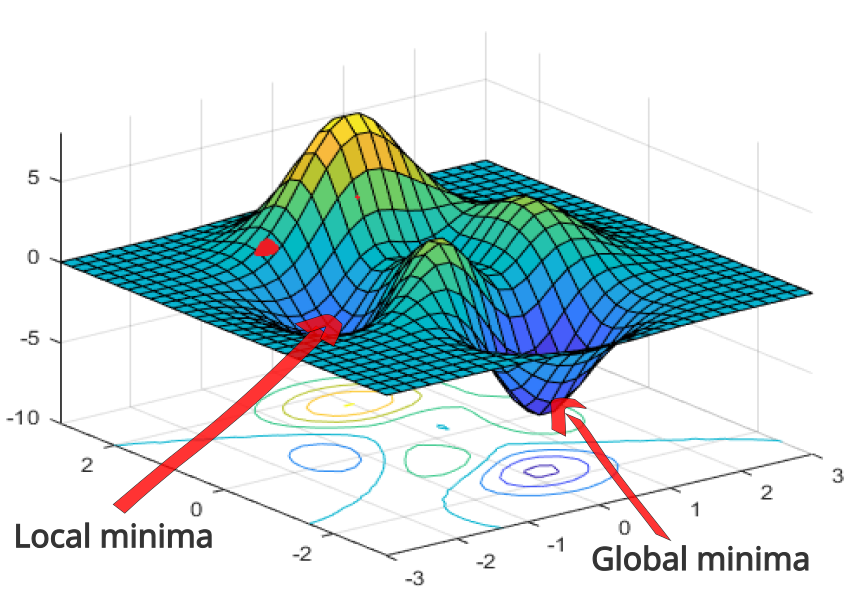


To get round this it's best to randomise your starting parameters everytime so your liklihood of finding the global minima is greater. The hmmlearn models has this built in, where if you don't set the transition probabilities beforehand it will randomise them.

In [ ]:
# No longer intialise the model with the transition and probability matrices
model = CategoricalHMM(n_components = len(hidden_states),  n_features = len(observables),params = 'ste', init_params = 'ste', verbose=True)

In [ ]:
# We now want to loop through the model multiple times, each time will have new starting matrices
# As it loops we'll need to save the best performing model to load and compare, we'll save it as a pickle
# Save the model to the data file with the name "2_state_model.pkl"
import pickle

save_path = 'USERS_PATH/HMM_tutorial/data/2_state_hmm.pkl'

iterations = 10 #  loop 10 times

for i in range(iterations):

    best_score = None
    best_model = None

    hmm = model.fit(seq_train, len_seq_train)
    print("True Convergence:" + str(hmm.monitor_.history[-1] - hmm.monitor_.history[-2] < hmm.monitor_.tol)) # If it converges rather than max iterations print True
    print("Final log liklihood score:" + str(hmm.score(seq_train, len_seq_train))) # Print the final log liklihood score

    score = hmm.score(seq_test, len_seq_test) # .score() generates a log probability score for the given observable, if its larger then previous best model it prints the new matrix and saves it
    
    # Store the first score as best_score and then compare it the next loop, if it scores better save it as the best model and score
    if best_score is None or best_score < score:
        best_score = score
        best_model = hmm
        print('New Matrix: \n')
        print(f'Transition matrix: \n {hmm.transmat_} \n')
        print(f'Emission probabilities: \n {hmm.emissionprob_}')

# Finally save the best model and print it's parameters
with open(save_path, "wb") as file: pickle.dump(best_model, file)
hmm_display(hmm, hidden_states, observables)

We can now be confident that if we run enough randomised iterations and with an appropriate tol we will likly end up with the best trained we could get given the dataset. We can now use this model to decode our observable sequence to a hidden state seqence.

Decoding your observables
======

In [ ]:
# We'll decode the first sequence of the test group
seq = test[0]
seq = seq.reshape(-1, 1) # It also needs to be reshped for decoding

# Call the .decode() method with the sequence inside the brackets
# The method returns two parts, the log liklihood for the sequence and the decoded sequence
log_prob, decoded_array = model.decode(seq)
print(f'Log probability of the state sequence: {log_prob}')
decoded_array

We have now successfully created a hidden markov model and decoded our observable data into our theorised sleep states, in the final notebook We'll look at how to understand the decoded data with graphs, as for now its meaningless to the eye. The next step we will look at making more complex hidden state architecture whilst retaining the lessons we've learned above.

Models with limited transitions
======

Going back to the first tutorial we will need to think about our observables and how they relate to our hidden states, and also how our hidden states interact with each other. In our mood example we assumed that each state could transition into each other, however biological systems are not always that free, often with certain routes state transitions must make to access others. Our example of sleep could be one such. Study of sleep in mammals has shown us that sleep stages are sequential, starting with REM sleep and transtitioning through progressive deep sleep stages. If we take this as our base we are going to want to restrict our hidden states so the sleep stages are only acessed by a lighter sleep that can transition into a deep sleep.

For this tutorial we will create a 4 hidden state model where we have two sleep states and two awake states. Deep sleep, light sleep, quiet awake, active awake. Where deep sleep can only be accessed through light sleep, and active awake can only be accessed through quiet awake.

It's oten easiest to look at these transition maps in pictograms:

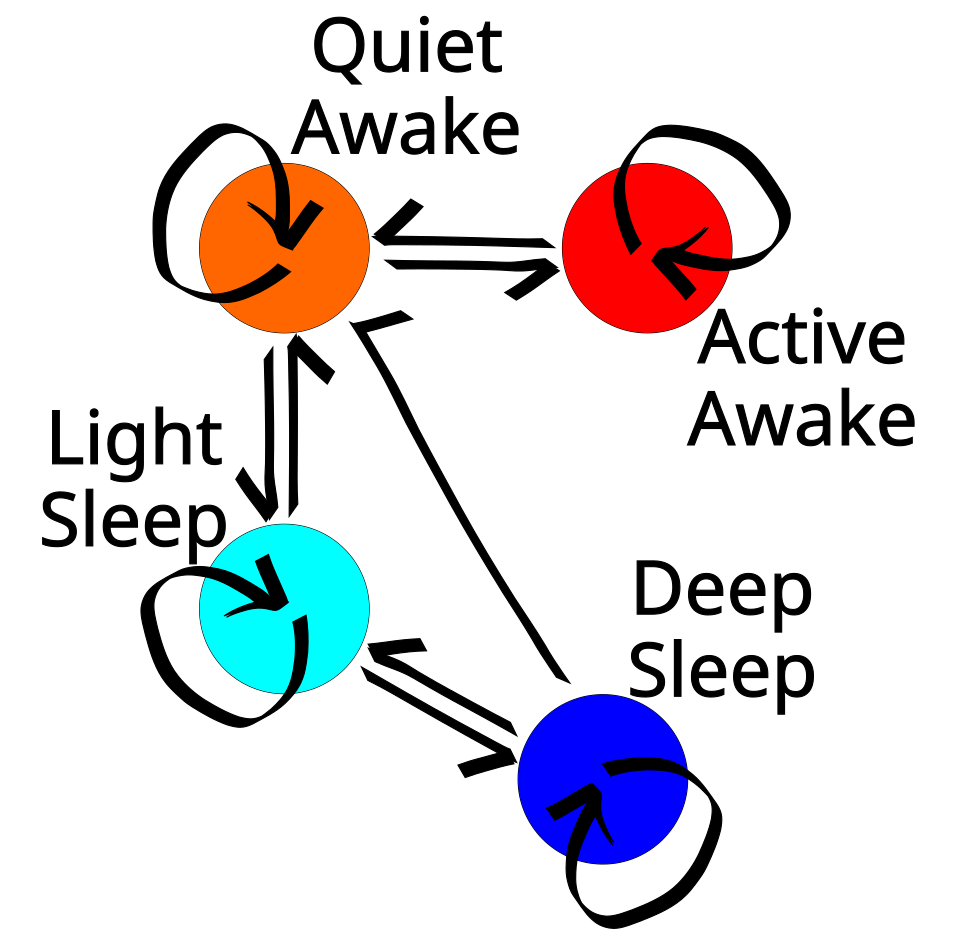

We now need to put the hidden states within context of the observables. Given the basic criteria for possible sleep is immobility we must make the model know that the observables micro movement and walking are off limits for the sleep states. Whereas the active states can have all the observables as emmissions.

Here they are added to the above pictogram:

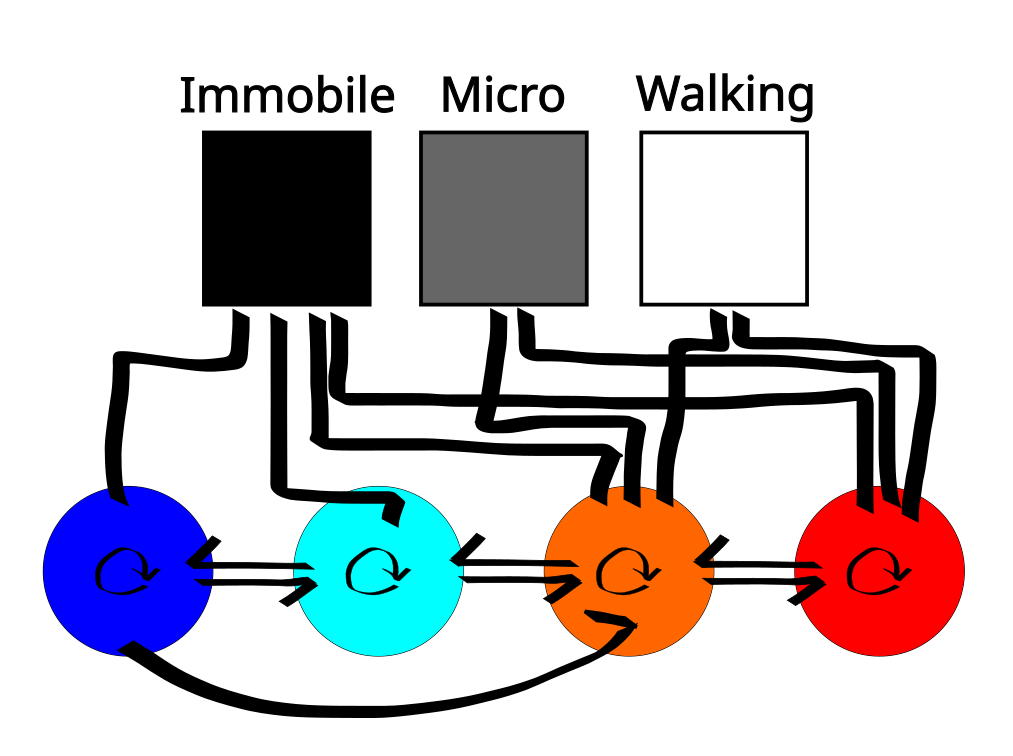

In [ ]:
# As for the 2 sate model create two lists detailing the names of the observables and hidden states
# observables = []
# hidden_states = []

observables = ['immobile', 'micro', 'walking']
hidden_states = ['deep sleep', 'light sleep', 'quiet awake', 'active awake']

In [ ]:
# As at the beginning we'll make a transition and emission probability matrix
# Where we give it a zero value it tells the model that these states can't transition into each other
# Taking the first row to be "deep sleep", the first entry is its transition probablity into itself, the next is into "light sleep", the next is "quiet awake", and finally we have its transition into "active awake"
# The next row is for "light sleep", but the columns stay the same, so the first entry is the transtion probabilty into "deep sleep", the second entry is for itself, and then so on.
# Remember the sum of each row must equal 1
t_prob = np.array([[0.6, 0.25, 0.15, 0.0],
                    [0.25, 0.6, 0.15, 0.0],
                    [0.0, 0.2, 0.5, 0.3],
                    [0.0, 0.0, 0.2, 0.8]])

# Now do the same for the emission probabilities given what emssions are allowed in the pictogram
# em_prob =  np.array(
#                     )

em_prob =  np.array([[1.0, 0.0, 0.0],
                    [1.0, 0.0, 0.0],
                    [0.1, 0.5, 0.4],
                    [0.05, 0.25, 0.7]])

In [ ]:
# We can now run the model
model = CategoricalHMM(n_components = len(hidden_states),  n_features = len(observables), params = 'ste', init_params = 's', verbose = True)
model.transmat_ = t_prob 
model.emissionprob_ = em_prob 
model.fit(seq_train, len_seq_train)

In [ ]:
# As we hoped setting the transition to 0 means it isn't updated at all 
hmm_display(model, hidden_states, observables)

However, some of you may have noticed a problem if we take the next step of randomising the transition and emission matrices before training, that we can't dictate to it to keep some as 0. We'll therefore have forgo the built-in hmmlearn randomising system and come up with a way to do it ourselves.

Randomising matrices
=====

In [ ]:
# A way to achieve certain values as random and others to stay as 0 is to have a place holder for numbers you wish to be randomised
# For ours we'll have all numbers we want randomised to be a string called 'rand'
t_prob_o = np.array([['rand', 'rand', 'rand', 0.0],
                    ['rand', 'rand', 'rand', 0.0],
                    [0.0, 'rand', 'rand', 'rand'],
                    [0.0, 0.0, 'rand', 'rand']])


em_prob_o =  np.array([[1.0, 0.0, 0.0],
                    [1.0, 0.0, 0.0],
                    ['rand', 'rand', 'rand'],
                    ['rand', 'rand', 'rand']])

In [ ]:
# numpy has a randomiser function np.random.random that generates a random number between 0 and 1
# list comprehension comes in useful here too
# As we have a nested array we call a list comprehension within another replacing 'rand' with a random number
t_prob = np.array([[np.random.random() if y == 'rand' else y for y in x] for x in t_prob_o], dtype = np.float64) # we need to dictate the value type in this as a float

# next we need to make the row sum to 1, we do this by getting the total and finding the fraction for each
t_prob = np.array([[y / sum(x) for y in x] for x in t_prob], dtype = np.float64)
t_prob

# Try running this cell multiple times to see the values randomise

Task:
Now try the same with the emission probabilities

In [ ]:
em_prob = 
em_prob = 

Final Task:
=====

Take everything we've now learned and train the 4 state model set out above. Have it loop through multiple times, randomising the transition and emission matrices. Play around with both the external and internal iteration numbers, as well as tol, to see whats the best score you can get for the model. Save the best model as '4_state_model.pkl'

In [ ]:
# Complete here